### The Story

This is about an Insurance company that has provided Health Insurance to its customers. The company needs help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company again.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

In order to predict, whether the customer would be interested in Vehicle insurance, we will use the below information: demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), and Policy (Premium, sourcing channel).

Therefore we are interested to predict the response of the customer to take up the insurance (Probability of response 'yes'). The evaluation metric for this project would be ROC_AUC score.

Source of data: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv


In [6]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [7]:
# to read the data:
insurance = pd.read_csv('insurance_data.csv')
insurance.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [8]:
# to check the missing values
insurance.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [9]:
# to see the data types and more information about the data:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    38000 non-null  int64  
 1   Gender                38000 non-null  object 
 2   Age                   38000 non-null  int64  
 3   Driving_License       38000 non-null  int64  
 4   Region_Code           38000 non-null  float64
 5   Previously_Insured    38000 non-null  int64  
 6   Vehicle_Age           38000 non-null  object 
 7   Vehicle_Damage        38000 non-null  object 
 8   Annual_Premium        38000 non-null  float64
 9   Policy_Sales_Channel  38000 non-null  float64
 10  Vintage               38000 non-null  int64  
 11  Response              38000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.5+ MB


In [10]:
# to check all the object columns:
insurence_object=insurance.select_dtypes(include=['object'])
insurence_object

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No
...,...,...,...
37995,Male,1-2 Year,Yes
37996,Female,1-2 Year,Yes
37997,Male,1-2 Year,Yes
37998,Female,< 1 Year,No


In [11]:
# To apply the label encoder to decode the binary categorical columns:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
insurance.Gender= le.fit_transform(insurance.Gender.values)
insurance.Vehicle_Damage= le.fit_transform(insurance.Vehicle_Damage.values)


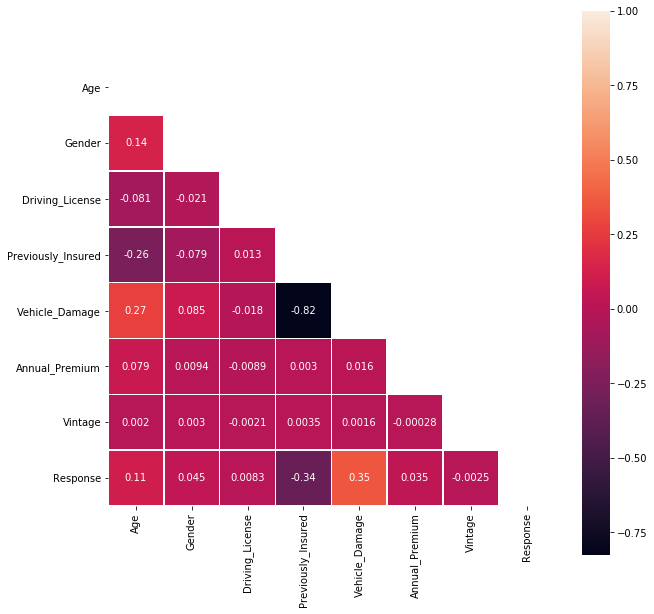

In [12]:
# To check the ccorrelation of the selected numerical columns:
f, b = plt.subplots(figsize=(10,10))
corr = insurance[['Age', 'Gender', 'Driving_License',
       'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'Response']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, linewidth=0.3, square=True, annot=True)

In [13]:
# To find out the highly correlated variables and then drop those columns when their corrlation is above +/-.95:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than +/-0.95
to_drop = [column for column in upper.columns if any(upper[column] < -0.95)]
to_drop1 = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)
print(to_drop1)

[]
[]


In [14]:
insurance['Vehicle_Age'].value_counts()

1-2 Year     19846
< 1 Year     16572
> 2 Years     1582
Name: Vehicle_Age, dtype: int64

In [15]:
# to decode and get dummies of the categorical data that has more than 2 categories, we use get_dummies:

dummies= pd.get_dummies(insurance['Vehicle_Age'])
insurance_1 = pd.concat([insurance, dummies], axis=1).drop(['Vehicle_Age'], axis=1)


In [16]:
# we decided to drop this column as it has lowest number data:
insurance_1.drop(['> 2 Years'], axis=1, inplace=True)

In [17]:
insurance_1['Response'].value_counts()

0    33375
1     4625
Name: Response, dtype: int64

In [18]:
# to rename the columns of dummies of vehicle age:
insurance_1.rename(columns={'1-2 Year':'VA_1_2_year', '< 1 Year':'VA_below_1_year'}, inplace=True)
insurance_1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'VA_1_2_year',
       'VA_below_1_year'],
      dtype='object')

#### Dataset with Standard Scaler 
Standardizing the features to mean 0 and variance 1. 

In [19]:
from sklearn.preprocessing import StandardScaler
to_transform = insurance_1[['Age', 'Annual_Premium','Vintage']]
# to select number type columns: data_num = insurance_2.select_dtypes(include=np.number)
transfor = StandardScaler().fit(to_transform)
transform_data= transfor.transform(to_transform)
transform = pd.DataFrame(transform_data, columns = to_transform.columns)
transform.head()
to_select = insurance_1[['Gender', 'Driving_License',
       'Previously_Insured', 'Vehicle_Damage', 'VA_1_2_year',
       'VA_below_1_year','Response']]

insurance_2=pd.concat([transform, to_select], axis=1)

#### Normalization: Dataset with Feature Scaling
This method delas with outliers. This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method. Outliers can often influence the sample mean / variance in a negative way. Therefore, the median and the interquartile range often give better results as compared to StandardScaler.

In [20]:
from sklearn.preprocessing import RobustScaler

to_fs = insurance_1[['Age','Annual_Premium','Vintage']]
to_fs_data= RobustScaler().fit(to_fs)
to_fs_data1 = to_fs_data.transform(to_fs)
fs_data = pd.DataFrame(to_fs_data1, columns= to_fs.columns)

insurance_3 = pd.concat([fs_data, to_select], axis=1)


### Modeling, Prediction, and Evaluation
#### preparation of data


In [21]:
# slpit the data into train and test:

from sklearn.model_selection import train_test_split 

y=insurance_1['Response']

X=insurance_1[['Age','Annual_Premium','Vintage',
               'Gender','Driving_License', 'Previously_Insured', 
               'Vehicle_Damage', 'VA_1_2_year','VA_below_1_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


#### Classification: Application of Logistic Regression on original dataset (not transformed, not normalised)

In [22]:
from sklearn.linear_model import LogisticRegression 

logistic_model=LogisticRegression().fit(X_train, y_train)
response_pred=logistic_model.predict(X_test)
response_pred = pd.Series(response_pred)

y_pred = pd.Series(response_pred, name='response_pred').value_counts()
y_tes = y_test.value_counts()

y_pred

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0    7593
1       7
Name: response_pred, dtype: int64

In [23]:
# Accuracy score of the Logistic Regression:
from sklearn.metrics import accuracy_score

print('Accuracy score of the logistic regression is: ', logistic_model.score(X_test, y_test))
# another way of accuracy score:
print ('accuracy score is: ', accuracy_score(y_test, response_pred))

Accuracy score of the logistic regression is:  0.8776315789473684
accuracy score is:  0.8776315789473684


In [24]:
pd.concat([y_tes, y_pred], axis=1)


,Response,response_pred
0,6675,7593
1,925,7


In [25]:
# printing out the performance scores:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision Score of LogisticRegression: ', precision_score(y_test, response_pred, pos_label=1))
print('Recall Score of LogisticRegression: ',recall_score(y_test, response_pred, pos_label=1))
print('f1 Score of LogisticRegression: ',f1_score(y_test, response_pred, pos_label=1))

Precision Score of LogisticRegression:  0.14285714285714285
Recall Score of LogisticRegression:  0.001081081081081081
f1 Score of LogisticRegression:  0.002145922746781116


Note: We applied the LogisticRegression to the Standardized and Normalized datasets, but the result did not improve, therefore we do not present those in here.

### In order to improve the model performance, we employ the DecisionTree model on the original data set (not standardized, not Normalized)

In [26]:
# DecisionTree on original data:
from sklearn.tree import DecisionTreeClassifier

decision_reg = DecisionTreeClassifier(random_state=100).fit(X_train, y_train)
decision_predict = decision_reg.predict(X_test)

response_precidt = pd.Series(decision_predict, name='response_pred').value_counts()

In [27]:
pd.concat([y_tes, response_precidt], axis=1)


,Response,response_pred
0,6675,6626
1,925,974


In [28]:
# Two ways to measure the accuracy:
print(decision_reg.score(X_test, y_test))
print(accuracy_score(y_test, decision_predict))

0.824078947368421
0.824078947368421


In [29]:
# To compute the feature importance:
#decision_reg.feature_importances_
print(dict(zip(X.columns, decision_reg.tree_.compute_feature_importances(normalize=True))))

{'Age': 0.17503713109141555, 'Annual_Premium': 0.30871258368622967, 'Vintage': 0.3252858458197777, 'Gender': 0.03357227618726653, 'Driving_License': 0.0006656624370508759, 'Previously_Insured': 0.011800104942263807, 'Vehicle_Damage': 0.12512896442257093, 'VA_1_2_year': 0.01583814822809373, 'VA_below_1_year': 0.0039592831853311064}


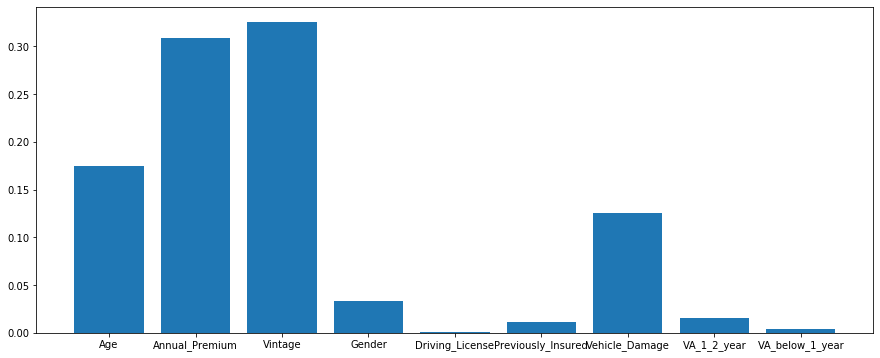

In [30]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.bar(height = decision_reg.feature_importances_, x = X.columns)
plt.show()

### Creatre Confusion_matrix for the DecisionTree

In [31]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, decision_predict)
print(cf_matrix)

[[5982  693]
 [ 644  281]]


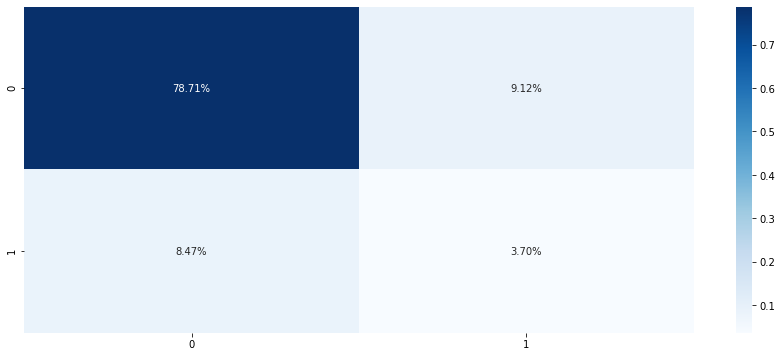

In [32]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [33]:
# We need to specify which 'Response' is the 'positive class'. Here, we are trying to predict whether a customer 
# will take up th einsurance, therefore class '1' is the 'positive' class.
print('Precision Score of DecisionTree: ',precision_score(y_test, decision_predict, pos_label=1))
print('recall Score of DecisionTree: ',recall_score(y_test, decision_predict, pos_label=1))
print('f1 Score of DecisionTree: ',f1_score(y_test, decision_predict, pos_label=1))

Precision Score of DecisionTree:  0.28850102669404515
recall Score of DecisionTree:  0.3037837837837838
f1 Score of DecisionTree:  0.29594523433385994


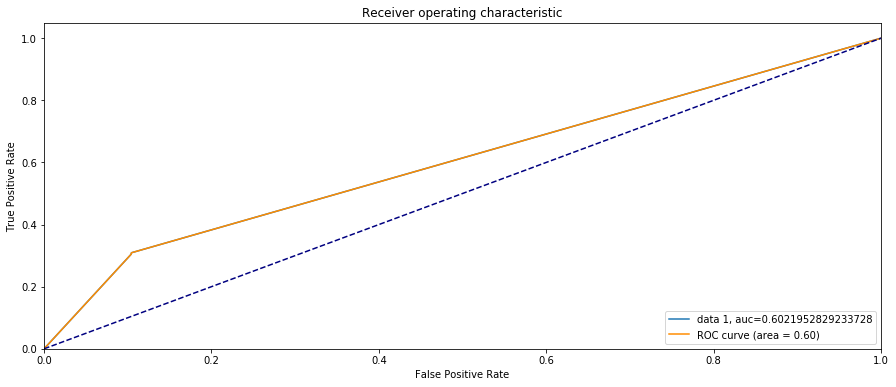

In [34]:
# ROC_AUC score for the DecisionTree:

from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba_dt = decision_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_dt)
auc = roc_auc_score(y_test, y_pred_proba_dt)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We applied the DecisionTree on Normalized and Standardized data but there was not a significant improvement, so we will go ahead with the original data.

### Dealing with imbalanced data - Under Sampling
Because our data is imbalanced (87% vs 13%), we have to deal with it. 
Random Undersampling:
Random undersampling reduces the number of majority class randomly down to the desired ratio against the minority class. This is probably the easiest way to undersample and can actually yield good results if there are a lot of the majority class instances that are close to each other.


However, most researches have pointed out that undersampling in most cases does produce better results than oversampling. In industrial practice, it has been reported that tech giants like Facebook and Microsoft also tend to use undersampling method when it comes to classifying their ad performance. The common argument is that undersampling is generally “cheaper” than oversampling and since the class of interest is the minority positive class, reducing some information of the majority negative class is acceptable. Once you have a well-balanced data, your model will potentially learn to classify different classes better for a more reliable prediction.

In [35]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)# test size should be small in under sampling


ModuleNotFoundError: No module named 'imblearn'

In [ ]:
# apply the UnderSampling on original data:
# summarize class distribution
print("Before undersampling: ", Counter(y_train))

In [ ]:
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

In [ ]:
# summarize class distribution
print("After undersampling: ", Counter(y_train_under))
#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_under = model.fit(X_train_under, y_train_under)
pred_under = clf_under.predict(X_test)

print("ROC AUC score for undersampled data: ", roc_auc_score(y_test, pred_under))

In [ ]:
X_test.shape

In [ ]:
X_train_under.shape

### Application of LogisticRegression on the original data that has been UnderSampled:


In [ ]:
    
logistic_model_u=LogisticRegression().fit(X_train_under, y_train_under)
response_pred_u=logistic_model_u.predict(X_test)
response_pred_u = pd.Series(response_pred_u)

y_pred_u = pd.Series(response_pred_u, name='response_pred').value_counts()
y_tes = y_test.value_counts()

print(y_pred_u)


In [ ]:
print('Precision Score of LogisticRegression for UnderSampled: ', precision_score(y_test, response_pred_u, pos_label=1))
print('Recall Score of LogisticRegression for UnderSampled: ', recall_score(y_test, response_pred_u, pos_label=1))
print('f1 Score of LogisticRegression for UnderSampled: ', f1_score(y_test, response_pred_u, pos_label=1))

In [ ]:
# to see the overall report of the various scores from the confusion matrix:
from sklearn.metrics import classification_report
print(classification_report(y_test, response_pred_u))

In [ ]:
# ROC_AUC score for LogisticRegression when undersampled:

y_pred_proba_u = logistic_model_u.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_u)
auc = roc_auc_score(y_test, y_pred_proba_u)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Undersampled')
plt.legend(loc="lower right")
plt.show()

##### Once we applied the  DecisionTree on the original data that has been UnderSampled, the result did not improve, so we are not presenting it here.


### Dealing with imbalanced data - Over Sampling


For over-sampling techniques, SMOTE (Synthetic Minority Oversampling Technique) is considered as one of the most popular and influential data sampling algorithms in ML and data mining. With SMOTE, the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement. These introduced synthetic examples are based along the line segments joining a defined number of k minority class nearest neighbours, which is in the imblearn package is set at five by default.


In [ ]:
# define oversampling strategy
y=insurance_1['Response']

X=insurance_1[['Age', 'Annual_Premium','Vintage',
               'Gender','Driving_License', 'Previously_Insured', 
               'Vehicle_Damage', 'VA_1_2_year','VA_below_1_year']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

#### Application of the LogisticRegression on the original data that has been OverSampled:


In [ ]:
logistic_model_o=LogisticRegression().fit(X_train_SMOTE, y_train_SMOTE)
response_pred_o=logistic_model_o.predict(X_test)
response_pred_o = pd.Series(response_pred_o)

y_pred_o = pd.Series(response_pred_o, name='response_pred').value_counts()
y_tes = y_test.value_counts()

print(y_pred_o)
print("Accuracy:", accuracy_score(y_test, response_pred_o))

print(precision_score(y_test, response_pred_o, pos_label=1))
print(recall_score(y_test, response_pred_o, pos_label=1))
print(f1_score(y_test, response_pred_o, pos_label=1))

### ROC Curve for OverSampling - case of Logistic regression on Original data
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

Example of Receiver Operating Characteristic (ROC) metric to evaluate classifier output quality.

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

In [ ]:
# ROC for Logistic Regression for Over Sample data:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba_o = logistic_model_o.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_o)
auc = roc_auc_score(y_test, y_pred_proba_o)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


As we can see, the ROC score was 0.84 for the case of UnderSampling model and 0.83 in the case of OverSampling, therefore we decided to proceed with UnderSampled data.

### Feature importance using LogisticRegression on original data undersampled, as this was the best model with highest ROC_AUC score


In [ ]:
import statsmodels.api as sm
X_u=X_train_under
y_u= y_train_under

logit_u = sm.Logit(y_u, X_u)
model_u=logit_u.fit()
print(model_u.summary())

#### Interpretation of the Logit results:

- Age: the older people are less likely to sign up for insurance.
- Annual premium: When the annual premium is high, it is more likely that people sign up.  
- Vintage: the coeff. is negative, means the longer the when customers are with the company, th eless the chance to sign up for new insurance.
- The coeff. for Gender (1=male) is positive, male customers are more likely to sign up for insurance.   
- The coeff. for Driving License (0 = no, 1=yes) is positive: people who have driving license are more likely to sign up for insurance.
- Previously Insured(1= Customer already has Vehicle Insurance): people who have already have insurance are less likely to sign up for insurance. 
- Vehicle Damage(1= Customer got his/her vehicle damaged in the past):  Customer whom their vehicle damaged in the past are more likely to sign up for insurance. 
- Vehicle age: customers whom their cars are '1-2 Year' old are less likely to sign up for insurance as compared to customers whom their cars are '> 2 Years' old. 
- Vehicle age: customers whom their cars are '< 1 Year' old are less likely to sign up for insurance as compared to customers whom their cars are '> 2 Years' old. 


In order to get a numerical gauge of the impact of each feature in the LogisticRegression model, the Odds Ratio is used. Odds ratios that are greater than 1 indicate that the event is more likely to occur as the predictor increases. Odds ratios that are less than 1 indicate that the event is less likely to occur as the predictor increases.


For categorical predictors, the odds ratio compares the odds of the event occurring at 2 different levels of the predictor. Odds ratios that are greater than 1 indicate that the event is more likely at level 1. Odds ratios that are less than 1 indicate that the event is less likely at level 1. 

In [ ]:
print(np.exp(model_u.params))

- Age: we can observe that Age has an ODDS Ratio of 0.976072, which indicates that one unit increase in Age increases the odds of signing up for insurance by 0.976072 times.


- Annual Premium: we can observe that Annual Premium has an ODDS Ratio of 1.000004, which indicates that one unit increase in Annual Premium increases the odds of signing up for insurance by 1.000004 times.


- Vintage: we can observe that vintage has an ODDS Ratio of 0.999717, which indicates that one unit increase in vintage increases the odds of signing up for insurance by 0.999717 times.



Odds ratios interpretation for categorical variables:


Odds ratios that are greater than 1 indicate that the people are more likely to sign up for insurance. Odds ratios that are less than 1 indicate that people are less likely to sign up for insurance:


- Gender: The odds ratio is 1.010406, which indicates that the odds that Male customers are more likely to sign up for insurance as compared to the female customers.


- Driving_License: The odds ratio is 1.231740, which indicates that the odds that the customers with driving license  are more likely to sign up for insurance as compared to the customers without driving license.


- Previously_Insured: The odds ratio is 0.027551 (less than 1), which indicates that the odds that the customers who previously insured are less likely to sign up for insurance as compared to the new customers.


- Vehicle_Damage: The odds ratio is 7.843875, which indicates that the odds that customers with vehicle damaged are more likely to sign up for insurance as compared to the customers with no vehicle damage.


- vehicle_Age (1-2 Year): The odds ratio is 0.844683 (less than 1), which indicates that the odds that the customers whose vehicle is '1-2 years' old are less likely to sign up for insurance as compared to the customers whose vehicle is '> 2 Years' old.


- vehicle_Age (< 1 Year): The odds ratio is 0.228496 (less than 1), which indicates that the odds that the customers whose vehicle is '< 1 Year' old are less likely to sign up for insurance as compared to the customers whose vehicle is '> 2 Years' old.


In [ ]:
# using LogisticRegression in Statsmodel provide us with the probability of each customer to take up insurance:
y_pred=model_u.predict(X_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head()

### Real word test

In order to test our best performed model, i.e., the 'logistic_model_u', we produce a pickle:

In [ ]:
import pickle

In [ ]:
logistic_model_u=LogisticRegression().fit(X_train_under, y_train_under)

In [ ]:
pickle.dump(logistic_model_u, open('my_model.pickle', 'wb'))

In [ ]:
def response():
    
    Age= input('Please enter your age - range of 20 and above:')
    while re.search('[0-9]',Age) is None:
        print('Make sure your age is in numbers') 
        Age= input('Please enter your age - range of 20 and above:')
    Annual_Premium = input('Please enter your desired Annual Premium - range of 2630 and more:')
    while re.search('[0-9]',Annual_Premium) is None:
        print('Make sure your Annual Premium is in numbers')
        Annual_Premium = input('Please enter your desired Annual Premium - range of 2630 and more:')
    Vintage = input('How many day have you been associated with our company - up to 300 days :')
    while re.search('[0-9]',Vintage) is None:
        print('Make sure your Vintage is in numbers')
        Vintage = input('How many day have you been associated with our company - up to 300 days :')

    Gender = input('Please enter your gender, Male=1, Female=0 :')
    while re.search('[0-1]',Gender) is None:
        print('Make sure your Gender is either 1 or 0')
        Gender = input('Please enter your gender, Male=1, Female=0 :')

    Driving_License = input('Do you have a Driving License? Yes=1, No=0 :')
    while re.search('[0-1]',Driving_License) is None:
        print('Make sure your Driving License either 1 or 0')
        Driving_License = input('Do you have a Driving License? Yes=1, No=0 :')

    Previously_Insured= input('Have you been previously insured with our company? Yes=1, No=0 :')
    while re.search('[0-1]',Previously_Insured) is None:
        print('Make sure that the value is either 1 or 0')
        Previously_Insured= input('Have you been previously insured with our company? Yes=1, No=0 :')

    Vehicle_Damage = input('Has your vehicle been damaged before? Yes=1, No=0 :')
    while re.search('[0-1]',Vehicle_Damage) is None:
        print('Make sure that your entry for vehicle damage is either 1 or 0')
        Vehicle_Damage = input('Has your vehicle been damaged before? Yes=1, No=0 :')

    VA_1_2_year = input('Is your vehicle 1-2 years old? Yes=1, No=0, if your answer is Yes, then please choose No in the next question:')
    while re.search('[0-1]',VA_1_2_year) is None:
        print('Make sure your entry is either 1 or 0')
        VA_1_2_year = input('Is your vehicle 1-2 years old? Yes=1, No=0, if your answer is Yes, then please choose No in the next question:')

    VA_below_1_year = input('Is your vehicle less than 1 year old? Yes=1, No=0: ')
    while re.search('[0-1]',VA_below_1_year) is None:
        print('Make sure your entry is either 1 or 0')
        VA_below_1_year = input('Is your vehicle less than 1 year old? Yes=1, No=0: ')

    #logistic_model_u=LogisticRegression().fit(X_train_under, y_train_under)
    loaded_model = pickle.load(open('my_model.pickle', 'rb'))
    parameters = ['Age', 'Annual_Premium', 'Vintage', 'Gender', 'Driving_License',
       'Previously_Insured', 'Vehicle_Damage', 'VA_1_2_year','VA_below_1_year']
    my_predictors = [Age, Annual_Premium, Vintage, Gender, Driving_License,
       Previously_Insured, Vehicle_Damage, VA_1_2_year ,VA_below_1_year]
    resp_data = dict(zip(parameters, my_predictors))
    resp_df = pd.DataFrame(resp_data, index=[0])
    #resp_y_pred= logistic_model_u.predict(resp_df)
    resp_y_pred= loaded_model.predict(resp_df)

    if resp_y_pred==1:
        return 'Hooray! This client is taking up our insurance plan'
    elif resp_y_pred==0:
        return 'Oops! This client is not taking up our insurance plan'
    #return f"Response: {float(resp_y_pred)}"

In [ ]:
response()